
Pytorch example2: Saving and Loading Models
==========

source:

- [Matthew Inkawhich](https://github.com/MatthewInkawhich)

modified by Sam, Liu

This document provides solutions to a variety of use cases regarding the
saving and loading of PyTorch models. Feel free to read the whole
document, or just skip to the code you need for a desired use case.

When it comes to saving and loading models, there are three core
functions to be familiar with:

1) torch.save:
   Saves a serialized object to disk. This function uses Python’s
   pickle utility
   for serialization. Models, tensors, and dictionaries of all kinds of
   objects can be saved using this function.

2) torch.load:
   Uses pickle’s
   unpickling facilities to deserialize pickled object files to memory.
   This function also facilitates the device to load the data into (see
   Saving & Loading Model Across
   Devices.

3) torch.nn.Module.load_state_dict:
   Loads a model’s parameter dictionary using a deserialized
   *state_dict*. For more information on *state_dict*, see What is a
   state_dict?.

**Contents:**
-  What is a state_dict?
-  Saving & Loading Model for
   Inference
-  Saving & Loading a General
   Checkpoint

In [1]:
from PIL import Image
import requests
import numpy as np
from io import BytesIO
from torch.utils import model_zoo
from torchvision import models
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline

What is a ``state_dict``?
-------------------------

In PyTorch, the learnable parameters (i.e. weights and biases) of an
``torch.nn.Module`` model is contained in the model’s ``parameters``
(accessed with ``model.parameters()``). A ``state_dict`` is simply a
Python dictionary object that maps each layer to its parameter tensor.
Note that only layers with learnable parameters (convolutional layers,
linear layers, etc.) have entries in the model’s state_dict. Optimizer
objects (``torch.optim``) also have a ``state_dict``, which contains
information about the optimizer’s state, as well as the hyperparameters
used.

Because state_dict objects are Python dictionaries, they can be easily
saved, updated, altered, and restored, adding a great deal of modularity
to PyTorch models and optimizers.


Let’s take a look at the ``state_dict`` from the simple model used in the
Training a classifier tutorial.

In [33]:
# Define model
class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
model = TheModelClass()

# Initialize optimizer
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, model.state_dict()[param_tensor].size())

print('============================================')    
    
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, optimizer.state_dict()[var_name])

Model's state_dict:
('conv1.weight', torch.Size([6, 3, 5, 5]))
('conv1.bias', torch.Size([6]))
('conv2.weight', torch.Size([16, 6, 5, 5]))
('conv2.bias', torch.Size([16]))
('fc1.weight', torch.Size([120, 400]))
('fc1.bias', torch.Size([120]))
('fc2.weight', torch.Size([84, 120]))
('fc2.bias', torch.Size([84]))
('fc3.weight', torch.Size([10, 84]))
('fc3.bias', torch.Size([10]))
Optimizer's state_dict:
('state', {})
('param_groups', [{'dampening': 0, 'nesterov': False, 'lr': 0.001, 'params': [140624080944656, 140624080943776, 140624080944576, 140624080942656, 140624080943696, 140624080944016, 140624080943296, 140624080944176, 140624080942896, 140624080943216], 'weight_decay': 0, 'momentum': 0.9}])


SAVING & LOADING MODEL FOR INFERENCE
-------------------------
There are many tools to load pretrained model in Pytorch, such as ``torch.load``,
``torchvision.models``, and ``torch.utils.model_zoo``. ``torch.load`` is used with
``torch.save``. <br>

A common PyTorch convention is to save models using either a ``.pt`` or ``.pth`` file extension.
### Save/Load state_dict (Recommended)

Save:

```python
torch.save(model.state_dict(), PATH)
```

Load:

```python
# If you are loading state dictionary from .pth file, you need to define network
# architecture first, then fit each weights of layer with .pth file 
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()
```

### Save/Load Entire Model

Save:

```python
# Save entire model object(included network architecture and weight) to file
torch.save(model, PATH)
```


Load:

```python
# If you are loading entire network object from .pth file, just load it directly.
model = torch.load(PATH)
```

The first saving/loading process is recommended way to load model because of its flexibility.

The second way saving/loading process uses the most intuitive syntax and involves the least amount of code. Saving a model in this way will save the entire module using Python’s pickle module. The disadvantage of this approach is that the serialized data is bound to the specific classes and the exact directory structure used when the model is saved. The reason for this is because pickle does not save the model class itself. Rather, it saves a path to the file containing the class, which is used during load time. Because of this, your code can break in various ways when used in other projects or after refactors.

Remember that you must call ``model.eval()`` to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results.

SAVING & LOADING A GENERAL CHECKPOINT FOR INFERENCE AND/OR RESUMING TRAINING
-------------------------
Save:

```python
torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        ...
        }, PATH)
```
Load:

```python    
model = TheModelClass(*args, **kwargs)
optimizer = TheOptimizerClass(*args, **kwargs)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
# - or -
model.train()
```

To load the items, first initialize the model and optimizer, then load the dictionary locally using ``torch.load()``. From here, you can easily access the saved items by simply querying the dictionary as you would expect.

Remember that you must call ``model.eval()`` to set dropout and batch normalization layers to evaluation mode before running inference. Failing to do this will yield inconsistent inference results. If you wish to resuming training, call ``model.train()`` to ensure these layers are in training mode.

# =======================
SAVING & LOADING MODEL EXAMPLE
-------------------------
There's an example that use other ways to load the model from network, one is using `torchvision.models` that include many popular neural network architecture, you can load only state_dict or entire model. The other one is ``torch.utils.model_zoo``. It can be used to download the state_dict from URL.

In [34]:
# Define a functio that can load an image from the Internet
def load(url, size=None):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    if size != None:
        img.thumbnail(size, Image.ANTIALIAS)
    return img

# Image pre-processing transforms
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [24]:
# Initialize the pre-trained model
squeezeNet = models.squeezenet1_1(pretrained=True)
squeezeNet.eval()

print('Type of squeezeNet: %s\n' %type(squeezeNet))
print('The contents of params_dict:')
print(squeezeNet)

Type of squeezeNet: <class 'torchvision.models.squeezenet.SqueezeNet'>

The contents of params_dict:
SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [25]:
params_dict = model_zoo.load_url('https://download.pytorch.org/models/squeezenet1_1-f364aa15.pth')
print('Type of params_dict: %s\n' %type(params_dict))
print('The contents of params_dict:')
for key,value in (params_dict.items()):
    print(key, tuple(value.shape))
    params_dict[key] = value

# If you load model from state_dict, you have to be familiar with the network architecture first.
# https://github.com/pytorch/vision/blob/master/torchvision/models/squeezenet.py
# squeezeNet = models.squeezenet1_1()
# print(squeezeNet)

Type of params_dict: <class 'collections.OrderedDict'>

The contents of params_dict:
('features.0.weight', (64, 3, 3, 3))
('features.0.bias', (64,))
('features.3.squeeze.weight', (16, 64, 1, 1))
('features.3.squeeze.bias', (16,))
('features.3.expand1x1.weight', (64, 16, 1, 1))
('features.3.expand1x1.bias', (64,))
('features.3.expand3x3.weight', (64, 16, 3, 3))
('features.3.expand3x3.bias', (64,))
('features.4.squeeze.weight', (16, 128, 1, 1))
('features.4.squeeze.bias', (16,))
('features.4.expand1x1.weight', (64, 16, 1, 1))
('features.4.expand1x1.bias', (64,))
('features.4.expand3x3.weight', (64, 16, 3, 3))
('features.4.expand3x3.bias', (64,))
('features.6.squeeze.weight', (32, 128, 1, 1))
('features.6.squeeze.bias', (32,))
('features.6.expand1x1.weight', (128, 32, 1, 1))
('features.6.expand1x1.bias', (128,))
('features.6.expand3x3.weight', (128, 32, 3, 3))
('features.6.expand3x3.bias', (128,))
('features.7.squeeze.weight', (32, 256, 1, 1))
('features.7.squeeze.bias', (32,))
('features

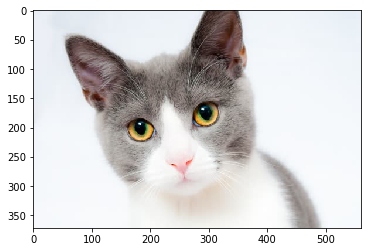

In [26]:
# Download a image from URL and transfer it to tensor
img_pil = load('http://s3.amazonaws.com/outcome-blog/wp-content/uploads/2017/02/25192225/cat.jpg')

# Apply transforms
img_tensor = preprocess(img_pil)

# Add one more dimension for batch size
img_tensor.unsqueeze_(0)

plt.imshow(img_pil)

In [27]:
# Download ImageNet labels and store them as a dict
LABELS_URL = 'http://s3.amazonaws.com/outcome-blog/imagenet/labels.json'
labels = {int(key):value for (key, value)
          in requests.get(LABELS_URL).json().items()}

# Forward pass without activation
fc_out = squeezeNet(img_tensor)

# Print network output and label
print(labels[fc_out.data.numpy().argmax()])


tabby, tabby cat
